In [2]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
from detecta import detect_peaks, detect_onset
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
kinematic_list = [i.replace('\\','/') for i in sorted(glob(f"c3d/**/*c3d"))]

kinematic_name = [os.path.basename(i).split('.')[0] for i in kinematic_list]

In [4]:
players = pd.read_excel(f'txt/player_information.xlsx',index_col = 'trial')
players

,weight,height
trial,,
S02_001,81,176
S02_002,81,176
S02_003,81,176
S02_004,81,176
S02_005,81,176


In [5]:
kinematic_names = {}

for i, name in zip(kinematic_list, kinematic_name):
    if 'right' in i:
        side = 'R'
    elif 'left' in i:
        side = 'L'

    weight = str(players.loc[name]['weight'])
    height = str(players.loc[name]['height'])

    new_name = f"{name}_{side}_{weight}_{height}"
    kinematic_names[i] = new_name

    new_file_path = os.path.join(os.path.dirname(i), new_name + '.c3d')
    os.rename(i, new_file_path)

    print(i)

KeyError: 'S02_001_R_81_176'

-------------

# Visual 3d 파이프라인 작업

-------------------

In [7]:
# 필터 적용 함수
def lowpass_filter(data, sr, cut_off, order):
    nyq = 0.5 * sr
    b, a = signal.butter(order, cut_off/nyq, btype = 'low')
    lp_df = signal.filtfilt(b, a, data)
    return lp_df

# 각속도 계산 함수 (sr: 샘플링 속도)
def ang_vel_made(data, sr):
    x = np.diff(data) / (1 / sr)
    x = pd.Series(x, index = np.arange(1,len(data)))
    return x    

In [8]:
file_list = [i.replace('\\','/') for i in sorted(glob(f"txt/**/*txt"))]
file_name = []
for i in file_list:
    file, _, _ = os.path.basename(i).split('.')
    file_name.append(file)
    
file_name

['S02_001_R_81_176',
 'S02_002_R_81_176',
 'S02_003_R_81_176',
 'S02_004_R_81_176',
 'S02_005_R_81_176']

In [9]:
dataset = {
    'force' : {},
    'kine'  : {}
    }

wrong = {     # 시점 컨택 안된 데이터 모으기
    'force' : {},
    'kine'  : {}
    } 

non_force = {}

for file, name in zip(file_list, file_name):
    df = pd.read_csv(file, sep='\t', encoding='cp949', header=[1,2,3,4])
    df.drop('Unnamed: 0_level_0', axis=1, inplace=True)
    df.drop('LAR_ROTMAT', axis=1, inplace=True)
    kinematic_len = len(df['FRAMES'].dropna())
    kinetic_len = kinematic_len * 16  # force를 kinematic의 몇 배로 설정했는지

    cols = []
    for col in df.columns:
        if col[0] not in ['FP1','FP2']:  # force 데이터 제외한 kinematic 데이터의 column만 저장
            cols.append(col)

    kine = df[cols].iloc[:kinematic_len, :]
    force = df[['FP1','FP2']].iloc[:kinetic_len,:]

    kg = float(name.split('_')[3])  # 몸무게 추출
    height = float(name.split('_')[4])  # 키 추출

    for_cols = []
    for col in force.columns:
        side, data, _, axis = col
        if side == 'FP1':
            side = 'First'
        else:
            side = 'Second'

        for_cols.append(f"{side}_{data}_{axis}")
        
    force.columns = for_cols

    # non_force[name] = force
    for col in for_cols:
        if ('FORCE' in col) | ('FREEMOMENT' in col):                            # cop는 필터링 안하는지?
            force[col] = lowpass_filter(force[col], 1080, 40, 4)  # 1080Hz / cutoff 40 / 4차 수정필요!!!!!!!!!!!
            force[col] = 100 * (force[col] / 9.81) / kg

    kine_cols = []
    for col in kine.columns:
        data, _, ro, axis = col
        if data in ['FRAMES','TIME']:
            kine_cols.append(data)
        elif data in ['ProxEndPos']:
            kine_cols.append(f"{ro}_{axis}")
        elif data in ['AngVel']:
            kine_cols.append(f"{data}_{ro}_{axis}")
        else:
            kine_cols.append(f"{data}_{axis}")

    kine.columns = kine_cols

    ang_cols = []
    vel_cols = []
    for col in kine_cols:
        if 'ANGLE' in col:
            ang_cols.append(col)
        if 'ANGULAR' or 'AngVel' in col:
            vel_cols.append(col)

    for col in ang_cols:
        up = np.where((np.diff(kine[col]) > 300))[0].tolist()
        down = np.where((np.diff(kine[col]) < -300))[0].tolist()
        all = sorted([*up, *down])
        all_len = len(all)

        if (len(up) == 0) & (len(down) == 0):
            pass
        
        elif (len(up) == 1) & (len(down) == 0):
            kine[col].iloc[all[0]+1:] = kine[col].iloc[all[0]+1:] - 360

        elif (len(up) == 0) & (len(down) == 1):
            kine[col].iloc[all[0]+1:] = kine[col].iloc[all[0]+1:] + 360

        elif (len(up) >= 1) & (len(down) >= 1):
            if up[0] < down[0]:
                if all_len % 2 == 0:
                    for i in range(0,all_len,2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] - 360
                elif all_len % 2 == 1:
                    for i in range(0,all_len - 1, 2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] - 360
                    kine[col].iloc[all[-1]+1:] = kine[col].iloc[all[-1]+1:] - 360                                               
            elif up[0] > down[0]:
                if all_len % 2 == 0:
                    for i in range(0,all_len,2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] + 360
                elif all_len % 2 == 1:
                    for i in range(0,all_len - 1, 2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] + 360
                    kine[col].iloc[all[-1]+1:] = kine[col].iloc[all[-1]+1:] + 360

    # 각도로 "각속도" 계산
    kine['PELVIS_ANGLUAR_VELOCITY_X'] = ang_vel_made(kine['PELVIS_ANGLE_X'], 180)  # 샘플링레이트 바꾸면 180 바꿔줘야 함!!!!!!!!!!!
    kine['PELVIS_ANGLUAR_VELOCITY_Y'] = ang_vel_made(kine['PELVIS_ANGLE_Y'], 180)
    kine['PELVIS_ANGLUAR_VELOCITY_Z'] = ang_vel_made(kine['PELVIS_ANGLE_Z'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_X'] = ang_vel_made(kine['TORSO_ANGLE_X'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_Y'] = ang_vel_made(kine['TORSO_ANGLE_Y'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_Z'] = ang_vel_made(kine['TORSO_ANGLE_Z'], 180)

    kine = kine.fillna(0)  # 결측치를 0으로 대체

    for col in kine.columns:
        if col not in ['FRAMES','TIME']:
            kine[col] = lowpass_filter(kine[col],180,13.4,4)  # 1080Hz / cutoff 13.4 / 4차 수정필요!!!!!!!!!!!
    
    '''
    for col in ang_cols:    
        if pit_type == 'L':
            split_col = col.split('_')
            if split_col[-1] in ['Y', 'Z']:
                kine[col] = - kine[col]
    
    for col in vel_cols:    
        if pit_type == 'L':
            split_col = col.split('_')
            if split_col[-1] in ['Y', 'Z']:
                kine[col] = - kine[col]
    '''
    session = f"{name.split('_')[0]}_{name.split('_')[1]}"

    sr = 180
    plot = False

    try:
        # print(f"===================={name}=======================")

        # visual3d 
        HS1 = detect_onset(kine['AngVel_LSK_X'], threshold=0, n_above=10, n_below=10, show=plot)[0][1]
        TO1 = detect_peaks(kine['AngVel_LSK_X'], mph=-2, mpd=50, valley=True, show=plot)[0]
        HS2 = detect_onset(kine['AngVel_LSK_X'], threshold=0, n_above=10, n_below=10, show=plot)[1][0]

        HS11 = detect_onset(kine['First_FORCE_Z'], threshold=1, n_above=10, n_below=10, show=plot)
        
        if HS1 > TO1:
            print(f'{name} : HS1가 TO1 보다 큼')
        if TO1 > HS2:
            print(f'{name} : TO1가 HS2보다 큼')

        kine['Heel_Strike1'] = HS1
        kine['Toe_Off1'] = TO1
        kine['Heel_Strike2'] = HS2

        force['Heel_Strike1'] = HS1 * 16  # force가 16배 이므로 바꿔야함
        force['Toe_Off1'] = TO1 * 16
        force['Heel_Strike2'] = HS2 * 16

        force.insert(0, 'FRAMES', range(1, len(force) + 1))

        '''
        First_lead_peak = detect_peaks(force['First_FORCE_Z'], mph=100, mpd=50, show=plot)
        force['First_peak_z'] = First_lead_peak[0]
        Second_lead_peak = detect_peaks(force['Second_FORCE_Z'], mph=100, mpd=50, show=plot)
        force['Second_peak_z'] = Second_lead_peak[0]
        '''
        
        dataset['force'][name] = force
        dataset['kine'][name] = kine

    except Exception:
        print(f"{name} 에서 시점 찾기 오류 발생")
        wrong['kine'][name] = kine
        wrong['force'][name] = force

S02_001_R_81_176 에서 시점 찾기 오류 발생
S02_002_R_81_176 에서 시점 찾기 오류 발생
S02_003_R_81_176 에서 시점 찾기 오류 발생
S02_004_R_81_176 에서 시점 찾기 오류 발생
S02_005_R_81_176 에서 시점 찾기 오류 발생


In [60]:
a = detect_onset(kine['AngVel_LSK_X'], threshold=0, n_above=10, n_below=10, show=plot)
a

array([[ 48,  69],
       [122, 142],
       [192, 212],
       [266, 300]], dtype=int64)

In [18]:
for name in dataset['kine']:
    kine = dataset['kine'][name]
    force = dataset['force'][name]
    kine.to_csv(f"csv/kine/{name}.csv", index=False)
    force.to_csv(f"csv/force/{name}.csv", index=False)

In [10]:
HS11

NameError: name 'HS11' is not defined

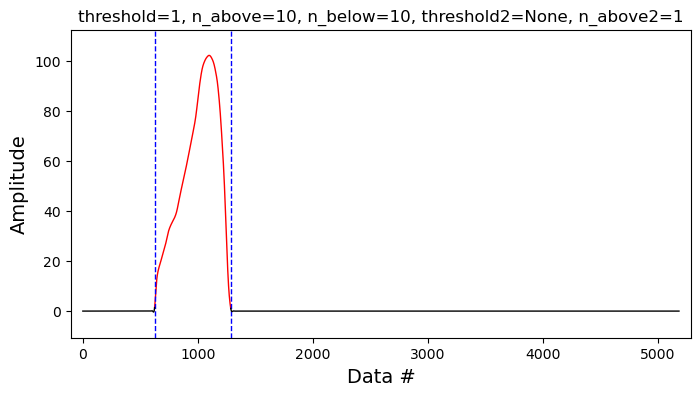

TypeError: only size-1 arrays can be converted to Python scalars

In [13]:
int(detect_onset(force['First_FORCE_Z'], threshold=1, n_above=10, n_below=10, show=True)/16)